In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

2024-03-05 13:49:51.418981: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:49:51.442489: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 13:49:51.442524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 13:49:51.442541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 13:49:51.447327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:49:51.448014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

IndexError: index 3 is out of bounds for axis 0 with size 3

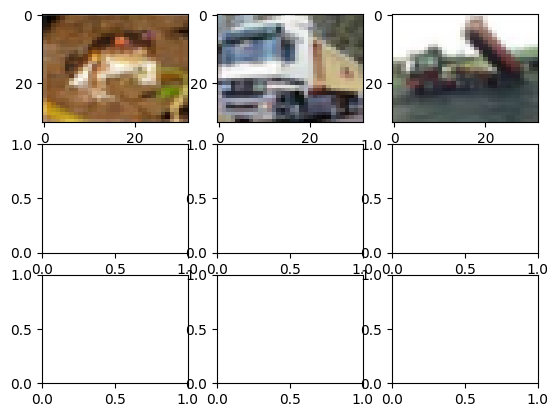

In [5]:
# visualize data by plotting images
fig, ax = plt.subplots(3, 3)
k = 0

for i in range(5):
	for j in range(5):
		ax[i][j].imshow(x_train[k], aspect='auto')
		k += 1

plt.show()

In [6]:
# number of classes
K = len(set(y_train))

# calculate total number of classes
# for output layer
print("number of classes:", K)

# Build the model using the functional API
# input layer
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

# Hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# last hidden layer i.e.. output layer
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# model description
model.summary()

number of classes: 10
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16,

2024-03-05 13:50:06.339449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 13:50:06.361778: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Compile
model.compile(optimizer='adam',
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy'])

In [8]:
# Fit with data augmentation
# Note: if you run this AFTER calling
# the previous model.fit()
# it will CONTINUE training where it left off
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

r = model.fit(train_generator, validation_data=(x_test, y_test),
			steps_per_epoch=steps_per_epoch, epochs=5,callbacks=[EarlyStopping(monitor="val_accuracy",patience=7,verbose=1)])

Epoch 1/5
1562/1562 [==============================] - 80s 51ms/step - loss: 1.4306 - accuracy: 0.5013 - val_loss: 1.1229 - val_accuracy: 0.6000
Epoch 2/5
1562/1562 [==============================] - 79s 51ms/step - loss: 0.9913 - accuracy: 0.6528 - val_loss: 0.9036 - val_accuracy: 0.6965
Epoch 3/5
1562/1562 [==============================] - 79s 51ms/step - loss: 0.8549 - accuracy: 0.7057 - val_loss: 0.9745 - val_accuracy: 0.6738
Epoch 4/5
1562/1562 [==============================] - 79s 51ms/step - loss: 0.7578 - accuracy: 0.7421 - val_loss: 0.6792 - val_accuracy: 0.7712
Epoch 5/5
1562/1562 [==============================] - 70s 45ms/step - loss: 0.6946 - accuracy: 0.7634 - val_loss: 0.7088 - val_accuracy: 0.7613


In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

313/313 [==============================] - 3s 9ms/step - loss: 0.7088 - accuracy: 0.7613
Test Accuracy: 76.13%


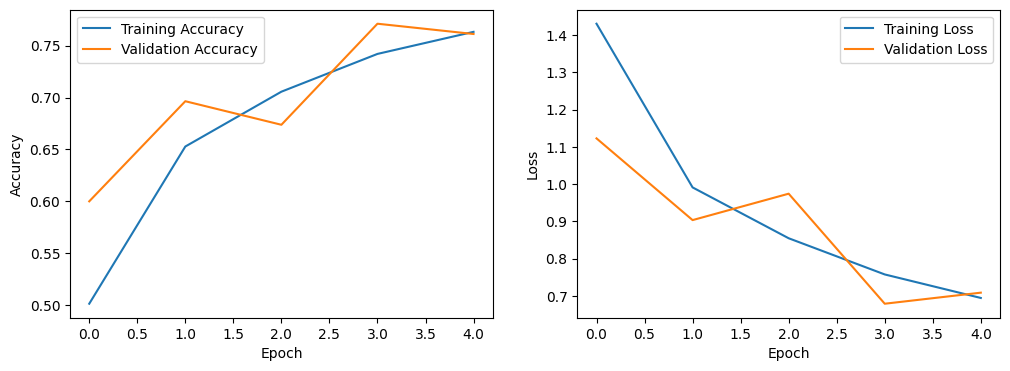

In [10]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

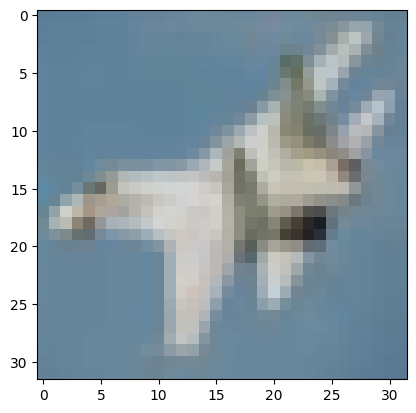

In [11]:
plt.imshow(x_test[10])

In [12]:
model.predict(x_test[10].reshape(1,32, 32, 3)).argmax(axis=1)
# array([0]) == plane

1/1 [==============================] - 0s 96ms/step


array([0])

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
import numpy as np

# Example data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Define your model
model = Sequential()
model.add(Dense(8, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, y, epochs=100, batch_size=2)

# Save the model
model.save('Model.h5')

# Later, if you want to load the model
# loaded_model = load_model('your_model.h5')


Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.2500
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7217 - accuracy: 0.2500
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7213 - accuracy: 0.2500
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7205 - accuracy: 0.2500
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7201 - accuracy: 0.2500
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.2500
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.2500
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.2500
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7173 - accuracy: 0.2500
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7162 - accuracy: 0.2500
Epoch 11/100
2/2 [===========

/home/indra/miniconda3/envs/ML/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
